# CYCLOPS on Hughes Liver Data (Boxplot: Sparse PCA)

## 1. Importing packages

In [1]:
from cyclops_v2 import *
from spca import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

Read the Hughes Liver data into a pandas dataframe:

In [2]:
df = pd.read_csv("Hughes_2009_liver_new.csv").T
df = df.iloc[1:,:]

In [3]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 9471 genes and 48 cells.


## 3. Data Preprocessing

Filter and sort genes in descending order of variance:

In [4]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9471 entries, 8364 to 541
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9471 non-null   float64
dtypes: float64(1)
memory usage: 148.0 KB


In [5]:
gene_list = df_std.index.to_numpy()
gene_list;

In [6]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(48, 9471)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [7]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470
0,-1.057233,0.590007,0.240254,0.828500,0.860009,0.604851,0.115542,0.291322,-1.612009,0.470272,...,0.047402,-0.033964,0.041124,0.048570,-0.036692,-0.008444,-0.007672,-0.003839,-0.003798,0.027638
1,-1.289151,-0.105554,0.258845,0.805143,0.925618,0.842084,0.055588,-0.316358,-1.014844,-0.345512,...,-0.054446,-0.056007,-0.026301,-0.033067,-0.048561,-0.038221,-0.029466,-0.014537,0.024404,0.015535
2,-1.480342,0.196870,0.125419,0.877522,0.489767,0.908341,0.401185,0.079972,-0.782121,-1.321644,...,0.021866,-0.042399,0.026469,-0.013850,-0.022070,0.000282,-0.004978,-0.042867,0.031460,0.006619
3,-1.853192,-0.367974,-0.221732,0.875994,2.026273,1.154509,1.674401,-0.020789,0.547587,-1.490179,...,0.016014,0.012643,0.037788,-0.010237,0.016415,0.036007,-0.020580,-0.013689,0.006455,0.011011
4,-1.999081,-1.076976,-0.307505,0.803293,0.922050,1.238456,1.191018,0.232353,-0.251958,-0.937067,...,-0.002610,-0.026173,0.048447,0.028801,-0.010934,0.061688,-0.054821,-0.039594,0.044793,-0.002803


## Karthik's SPCA

#### Convert the dataframe to a numpy array:

In [8]:
data_ = df_cent.to_numpy()

#### _t_ controls alpha, _ rank_ controls n_components

In [9]:
n_components = 9
alpha = 8
test = rank_n_o(data_, t=alpha, tol=10e-4, rank=n_components)

In [10]:
for k, v in test.items():
    if k=='XV':
        spca_eigengenes = pd.DataFrame(v)
    if k=='V':
        loading_vectors = pd.DataFrame(v)

#### Loading vectors:

In [11]:
loading_vectors = loading_vectors[(loading_vectors.select_dtypes(include=['number']) != 0).any(1)]
loading_vectors.head()

,0,1,2,3,4,5,6,7,8
0,-0.456205,0.275388,0.000000,0.000000,0.0,0.000000,0.101856,0.005560,-0.047828
1,-0.251519,-0.128345,0.246941,0.000000,0.0,-0.023008,0.000000,-0.016274,0.000000
2,-0.246036,0.000000,0.266685,-0.067236,0.0,0.000000,0.000000,0.000000,-0.037039
3,0.253311,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.058886,0.098658,0.000000,0.000000,0.0,0.359986,-0.040532,-0.525322,0.043855


#### Eigengenes:

In [12]:
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,2.861646,-2.555304,4.046580,-0.212916,1.559651,0.949264,3.571554,-2.997308,-2.981320
1,3.782134,-1.697651,3.018349,-1.452808,-0.388124,1.107676,2.343453,-1.993671,-1.151872
2,3.961757,-0.973856,2.509441,-2.929817,-1.195923,0.061350,2.010507,-1.825753,-0.773722
3,4.827207,0.680977,1.469164,-3.078819,-0.848709,1.208102,-0.189652,-4.101066,1.961160
4,5.060407,0.322208,2.936977,-3.924132,2.737659,2.132296,0.293697,0.908527,0.010329


__Clip__ the values in each eigengene to deal with outliers:

In [13]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,2.861646,-2.555304,2.909067,-0.212916,1.559651,0.949264,2.303459,-2.250793,-2.721658
1,3.782134,-1.697651,2.909067,-1.452808,-0.388124,1.107676,2.303459,-1.993671,-1.151872
2,3.961757,-0.973856,2.509441,-2.929817,-1.195923,0.061350,2.010507,-1.825753,-0.773722
3,4.827207,0.680977,1.469164,-3.026668,-0.848709,1.208102,-0.189652,-2.250793,1.961160
4,5.060407,0.322208,2.909067,-3.026668,2.737659,2.132296,0.293697,0.908527,0.010329


Sort the eigengenes in descending order of variance:

In [14]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([0, 1, 2, 4, 5, 3, 7, 8, 6])

Reorder the columns of the dataframe in descending order of variance:

In [15]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

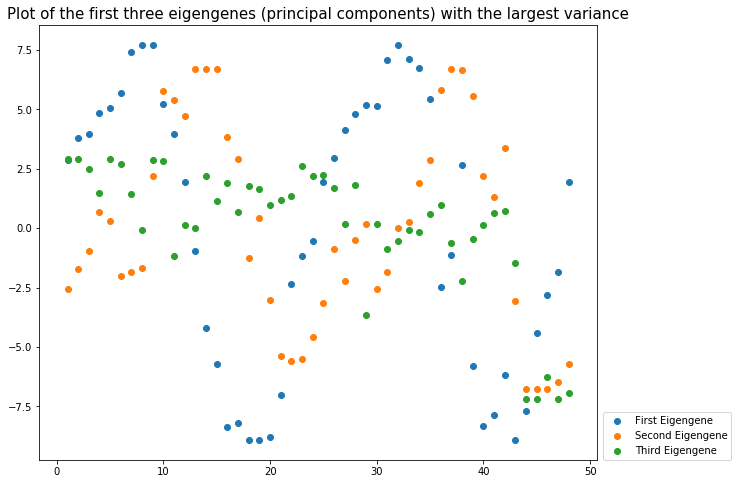

In [16]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

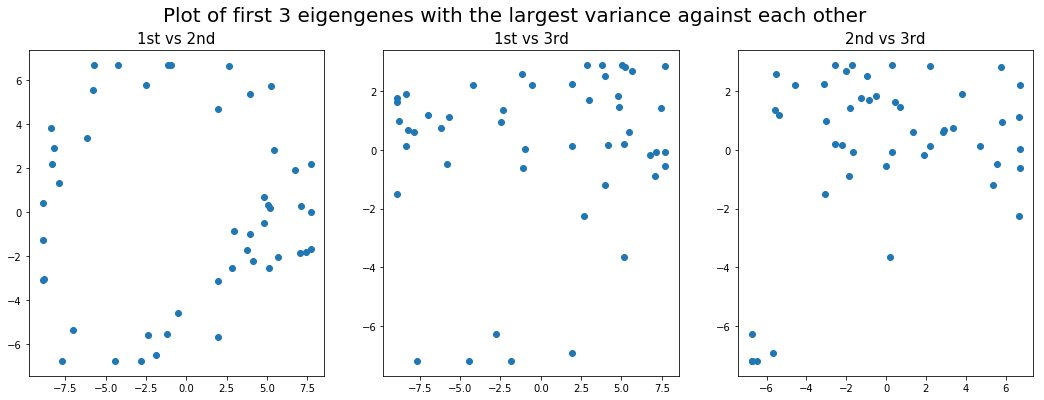

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [18]:
data = spca_eigengenes.to_numpy()

In [19]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    for i in range(1,len(X)):
        if X[i]-X[i-1]<10:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

def iterr(data):
    model = cyclops(data.shape[1])
    n_epochs = 500
    history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=n_epochs, verbose=n_epochs, batch_size=10)

    loss = history.history['loss'][-1]
    
    phase_df = model.phase_output(data)
    phase_idx = phase_df.index.to_numpy()
    phase_list = phase_df.pseudotime.to_numpy()
    
    zipped = list(zip(phase_idx,phase_list))
    re_phase_list = np.array([sorted(zipped, key = lambda t: t[0])[i][1] for i in range(len(zipped))])
    re_phase_idx = np.array([sorted(zipped, key = lambda t: t[0])[i][0] for i in range(len(zipped))])
    
    asc_phase_jump, desc_phase_jump = [],[]
    for i in range(len(re_phase_list)-1):
        if re_phase_list[i+1]-re_phase_list[i] > np.pi:
            desc_phase_jump.append(i)
        elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
            asc_phase_jump.append(i)
            
    if len(asc_phase_jump) > len(desc_phase_jump):
        phase_jump = asc_phase_jump
    else:
        phase_jump = desc_phase_jump


    phase_jump = jump_control(phase_jump)

    jumps = len(phase_jump)
    for i in range(jumps):
        if len(asc_phase_jump) > len(desc_phase_jump):
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(len(zipped))])
        else:
            re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(len(zipped))])
        phase_jump.pop(0)
    
    from scipy.stats import linregress

    lin = linregress(re_phase_idx, re_phase_list)
    
    r_squared = lin[2]**2
    
    return loss, r_squared

In [20]:
%%capture
%%time

n_iter = 50

iter_list = np.zeros([n_iter,2])

for i in range(n_iter):
    iter_list[i] = iterr(data)

In [21]:
cs = np.array([iter_list[i][0] for i in range(len(iter_list))])
r2 = np.array([iter_list[i][1] for i in range(len(iter_list))])

/Users/henrylim/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


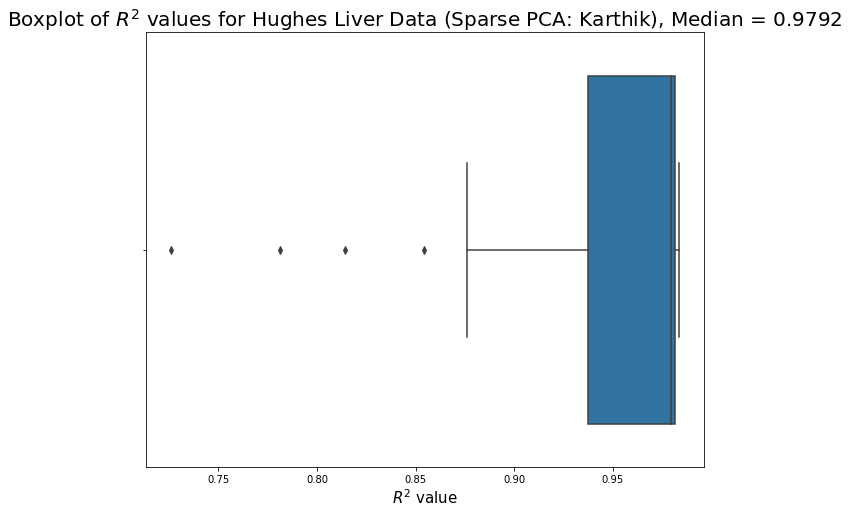

In [22]:
import seaborn as sns
import statistics

plt.figure(figsize=(10,8))
sns.boxplot(r2)
plt.xlabel(r'$R^2$ value', size=15)
plt.title(r'Boxplot of $R^2$ values for Hughes Liver Data (Sparse PCA: Karthik), Median = {:.4f}'.format(statistics.median(r2)), size=20)
plt.show()